In [ ]:
!pip install torch
!pip install torch_geometric
!pip install captum

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import math
import torch
from torch_geometric.nn import GATConv
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
from imblearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv("/content/Dataset.csv")

# EDA

In [ ]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,11,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',52.35,0
1,172,'C1222389110','3','M','28007','M1823072687','28007','es_transportation',14.75,0
2,106,'C879949041','3','F','28007','M1823072687','28007','es_transportation',3.73,0
3,86,'C409740988','5','M','28007','M1823072687','28007','es_transportation',61.42,0
4,152,'C671449181','3','F','28007','M692898500','28007','es_health',9.05,0


In [ ]:
df.shape

(535178, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535178 entries, 0 to 535177
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         535178 non-null  int64  
 1   customer     535178 non-null  object 
 2   age          535178 non-null  object 
 3   gender       535178 non-null  object 
 4   zipcodeOri   535178 non-null  object 
 5   merchant     535178 non-null  object 
 6   zipMerchant  535178 non-null  object 
 7   category     535178 non-null  object 
 8   amount       535178 non-null  float64
 9   fraud        535178 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 40.8+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,535178.0,94.982225,51.056459,0.0,52.00,97.0,139.00,179.00
amount,535178.0,37.945166,112.585244,0.0,13.73,26.9,42.57,8329.96
fraud,535178.0,0.012131,0.109469,0.0,0.00,0.0,0.00,1.00


> * The amount category tells us about the transaction amount. Looking at the mean of amount which lies at 37 and looking at the median (50% quartile), we can see that the data is a bit skewed which is common in financial data as large amounts can shift the mean.

> * The std being higher than mean also tells us there is a lot of variety in the data.

> * There are also a few large outliers (max is much higher than 75% quartile).

In [ ]:
df.isnull().sum()

,0
step,0
customer,0
age,0
gender,0
zipcodeOri,0
merchant,0
zipMerchant,0
category,0
amount,0
fraud,0


In [ ]:
# Check rows with null
print("NaN value rows: ")
rows_with_null = df[df.isnull().any(axis=1)]
print(rows_with_null)

# Find duplicate rows
print("\n")
print("Duplicate value rows: ")
duplicates = df[df.duplicated()]
print(duplicates)

NaN value rows: 
Empty DataFrame
Columns: [step, customer, age, gender, zipcodeOri, merchant, zipMerchant, category, amount, fraud]
Index: []


Duplicate value rows: 
Empty DataFrame
Columns: [step, customer, age, gender, zipcodeOri, merchant, zipMerchant, category, amount, fraud]
Index: []


In [ ]:
# Drop rows with any NaN values
df_up = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535178 entries, 0 to 535177
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         535178 non-null  int64  
 1   customer     535178 non-null  object 
 2   age          535178 non-null  object 
 3   gender       535178 non-null  object 
 4   zipcodeOri   535178 non-null  object 
 5   merchant     535178 non-null  object 
 6   zipMerchant  535178 non-null  object 
 7   category     535178 non-null  object 
 8   amount       535178 non-null  float64
 9   fraud        535178 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 40.8+ MB
None


In [ ]:
# to print unique vals
for column in df_up.columns:
    print(f"Column: {column}")

    # Unique values
    unique_values = df_up[column].unique()
    print(f"Unique values: {unique_values[:5]}...")
    print(f"Total unique values: {len(unique_values)}")

    # Number of unique values
    unique_count = df_up[column].nunique()
    print(f"Number of unique values: {unique_count}")

    # Value counts
    value_counts = df_up[column].value_counts()
    print(f"Value counts:\n{value_counts.head(5)}")
    print("\n" + "-"*50 + "\n")

Column: step
Unique values: [ 11 172 106  86 152]...
Total unique values: 180
Number of unique values: 180
Value counts:
step
173    3376
177    3374
179    3372
152    3370
169    3367
Name: count, dtype: int64

--------------------------------------------------

Column: customer
Unique values: ["'C1760492708'" "'C1222389110'" "'C879949041'" "'C409740988'"
 "'C671449181'"]...
Total unique values: 4112
Number of unique values: 4112
Value counts:
customer
'C1978250683'    240
'C1275518867'    229
'C806399525'     218
'C515668508'     189
'C1338396147'    177
Name: count, dtype: int64

--------------------------------------------------

Column: age
Unique values: ["'1'" "'3'" "'5'" "'2'" "'4'"]...
Total unique values: 8
Number of unique values: 8
Value counts:
age
'2'    168425
'3'    132505
'4'     98068
'5'     56465
'1'     52384
Name: count, dtype: int64

--------------------------------------------------

Column: gender
Unique values: ["'F'" "'M'" "'E'" "'U'"]...
Total unique values

In [ ]:
df_up['fraud'] = df_up['fraud'].astype(int)

In [ ]:
# assigning cols
numerical_cols_wo = df.select_dtypes(include=['float64', 'int64']).drop(columns=['fraud']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['age', 'gender', 'category']

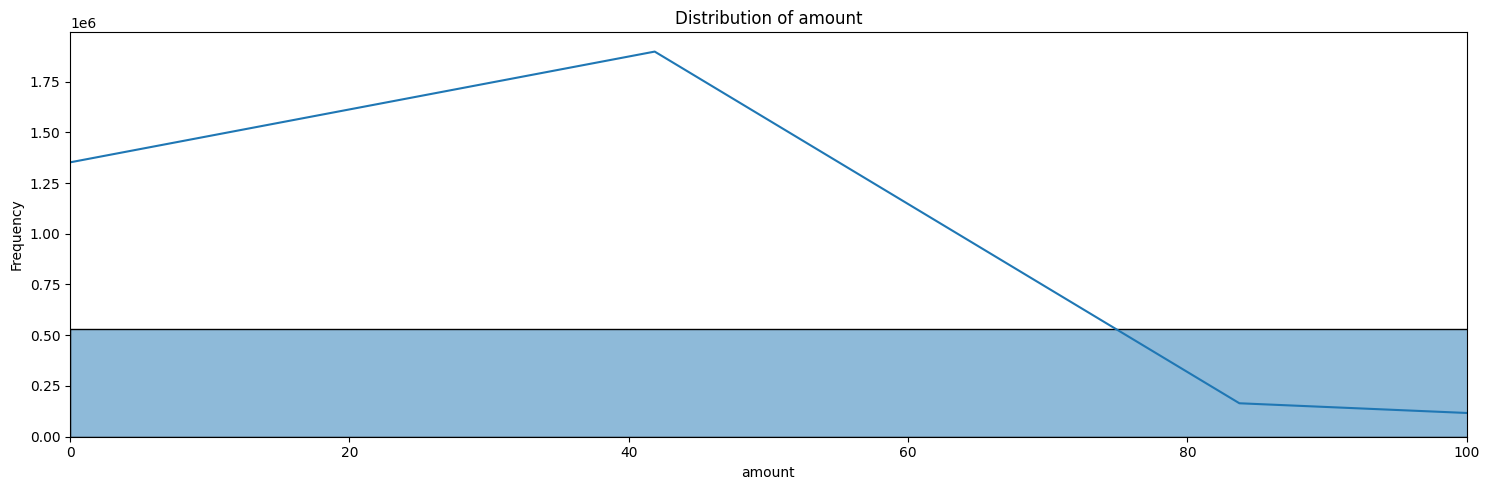

In [ ]:
col = 'amount'
plt.figure(figsize=(15, 5))
sns.histplot(df[col], kde=True, bins=30)
plt.title(f'Distribution of {col}')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

In [ ]:
print((df_up.groupby('category')['fraud'].mean()*100).reset_index().rename(columns={'category':'category','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

                   category  Fraud Percent
1             'es_contents'       0.000000
3                 'es_food'       0.000000
12      'es_transportation'       0.000000
2              'es_fashion'       1.826641
0   'es_barsandrestaurants'       1.896225
7                'es_hyper'       4.642202
14   'es_wellnessandbeauty'       4.854012
11                'es_tech'       6.672888
4               'es_health'      10.438242
5                 'es_home'      15.093273
9        'es_otherservices'      24.632353
6        'es_hotelservices'      31.202046
10       'es_sportsandtoys'      49.458183
13              'es_travel'      79.279279
8              'es_leisure'      95.175439


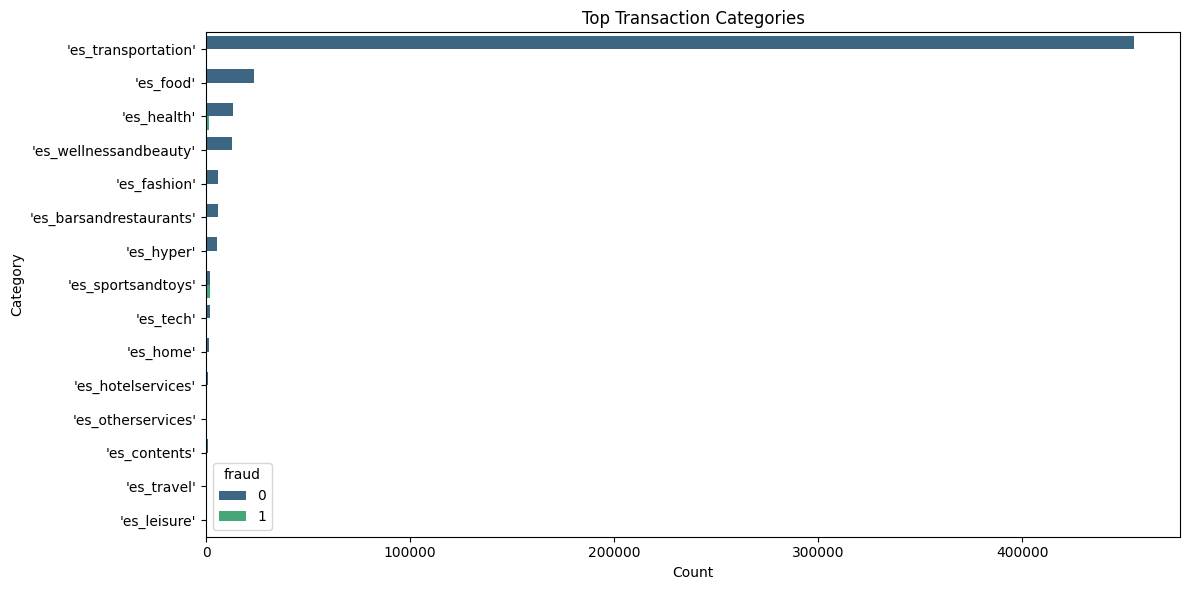

In [ ]:
# Top Transaction Categories
plt.figure(figsize=(12, 6))
top_categories = df_up['category'].value_counts().nlargest(15).index
sns.countplot(y='category', data=df_up, order=top_categories, hue=df_up['fraud'], palette='viridis')
plt.title('Top Transaction Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [ ]:
print((df_up.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'category':'category','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   age  Fraud Percent
7  'U'       0.567644
6  '6'       1.005359
5  '5'       1.103338
1  '1'       1.200748
3  '3'       1.202219
2  '2'       1.247440
4  '4'       1.281764
0  '0'       1.861099


In [ ]:
print((df_up.groupby('gender')['fraud'].mean()*100).reset_index().rename(columns={'category':'category','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

  gender  Fraud Percent
3    'U'       0.000000
0    'E'       0.567644
2    'M'       0.911134
1    'F'       1.467014


In [ ]:
print(df['fraud'].value_counts())
print(df['fraud'].value_counts(normalize=True) * 100)

fraud
0    528686
1      6492
Name: count, dtype: int64
fraud
0    98.786946
1     1.213054
Name: proportion, dtype: float64


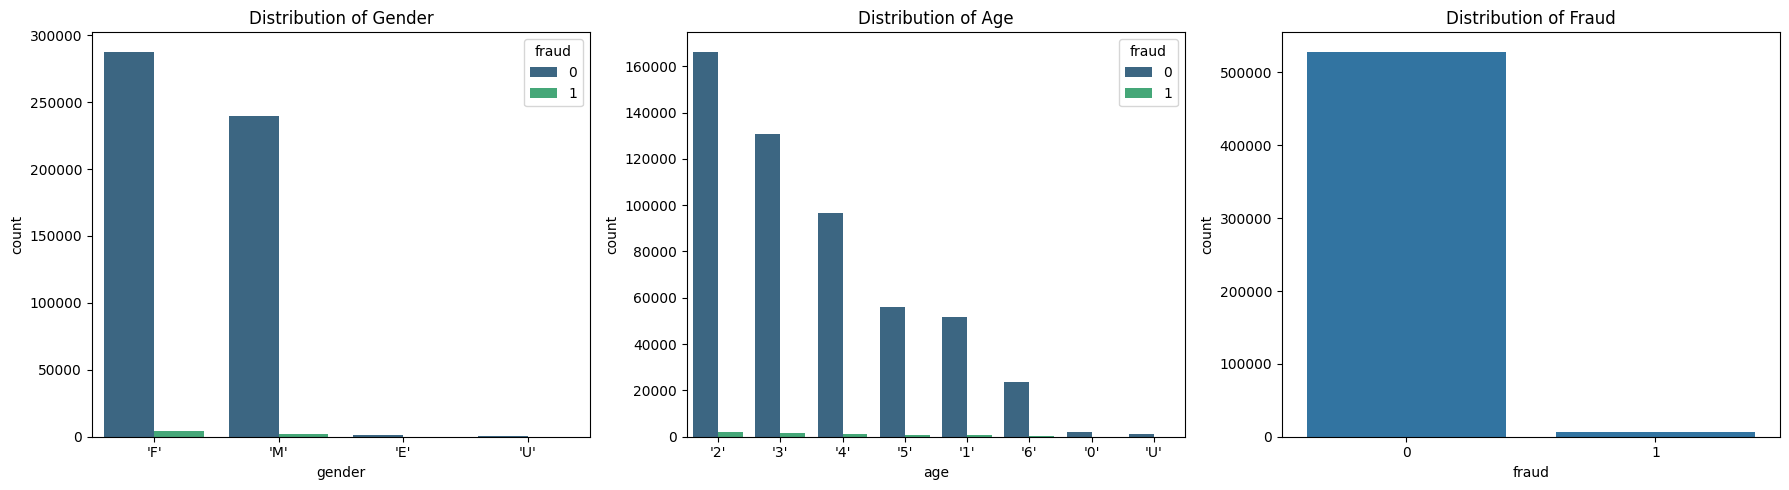

In [ ]:
plt.figure(figsize=(18, 5))

# Gender Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='gender', data=df_up, hue=df['fraud'], palette='viridis')
plt.title('Distribution of Gender')

# Age Distribution
plt.subplot(1, 3, 2)
sns.countplot(x='age', data=df_up, hue=df['fraud'], palette='viridis', order = df_up['age'].value_counts().index)
plt.title('Distribution of Age')

# Fraud Distribution
plt.subplot(1, 3, 3)
sns.countplot(x='fraud', data=df_up)
plt.title('Distribution of Fraud')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Group by merchant and get overall value counts
merchant_counts = df['merchant'].value_counts().rename('Total_Transactions')

# Group by merchant and calculate fraud rate
fraud_stats = df.groupby('merchant')['fraud'].agg(
    Total_Transactions='count',
    Fraud_Count='sum',
    NonFraud_Count=lambda x: (x == 0).sum()
)
fraud_stats['Fraud_%'] = 100 * fraud_stats['Fraud_Count'] / fraud_stats['Total_Transactions']
fraud_stats['NonFraud_%'] = 100 * fraud_stats['NonFraud_Count'] / fraud_stats['Total_Transactions']

# Get most frequent customer per merchant
top_customers = (
    df.groupby(['merchant', 'customer'])
    .size()
    .reset_index(name='Transaction_Count')
    .sort_values(['merchant', 'Transaction_Count'], ascending=[True, False])
    .drop_duplicates(subset=['merchant'])
    .set_index('merchant')
)

# Join with fraud_stats
merged = fraud_stats.join(top_customers[['customer', 'Transaction_Count']])
merged.rename(columns={'customer': 'Top_Customer', 'Transaction_Count': 'Top_Customer_Txns'}, inplace=True)

# Calculate fraud rate of the top customer for each merchant
top_customer_fraud = (
    df.merge(merged[['Top_Customer']], left_on='merchant', right_index=True)
      .query('customer == Top_Customer')
      .groupby('merchant')['fraud']
      .agg(
          Top_Customer_Total='count',
          Top_Customer_Fraud='sum'
      )
)
top_customer_fraud['Top_Customer_Fraud_%'] = 100 * top_customer_fraud['Top_Customer_Fraud'] / top_customer_fraud['Top_Customer_Total']

# Final merge
final = merged.join(top_customer_fraud)

# Sort by fraud % committed by merchant
final_sorted = final.sort_values(by='Fraud_%', ascending=False)

# Display
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(final_sorted[['Total_Transactions', 'Fraud_%', 'NonFraud_%', 'Top_Customer', 'Top_Customer_Txns', 'Top_Customer_Fraud_%']])

               Total_Transactions    Fraud_%  NonFraud_%   Top_Customer  Top_Customer_Txns  Top_Customer_Fraud_%
merchant                                                                                                        
'M1294758098'                 172  96.511628    3.488372  'C1849046345'                  6            100.000000
'M3697346'                    284  94.366197    5.633803  'C1275518867'                  6            100.000000
'M1873032707'                 228  86.403509   13.596491  'C2004941826'                  6            100.000000
'M732195782'                  559  84.973166   15.026834   'C806399525'                 12            100.000000
'M980657600'                 1593  83.050847   16.949153  'C1275518867'                 35            100.000000
'M1353266412'                  69  82.608696   17.391304  'C1849046345'                  4            100.000000
'M857378720'                  110  75.454545   24.545455  'C1849046345'                  5      

> ## Merchant-Customer Risk

> * High-Risk Merchants are Clear: A small number of merchants are responsible for a disproportionately high percentage of fraudulent transactions. For instance, merchants like 'M1294758098' (97.6% fraud) and 'M1873032707' (94.4% fraud) have displayed active fraudulent behaviour.

> * Zero-Fraud Merchants: A significant number of merchants have a 0% fraud rate. This is valuable information. It suggests that many merchants are either not targeted by fraudsters or have effective fraud prevention measures in place. The merchants with the highest transaction volumes, 'M1823072687' (58,423 transactions) and 'M348934600' (40,118 transactions), are in this zero-fraud group.

> The Top_Customer and Top_Customer_Fraud_% columns tell us the following things:

> * For many high-fraud merchants, the top customer has a 100% fraud rate, indicating a likely fraudulent actor is concentrating their efforts on specific merchants.

> * The customer 'C2004941826' is the top customer for two different merchants, one with a high fraud rate ('M980657600') and one with a lower fraud rate, which could be a very active customer or a fraudster operating across multiple merchants.

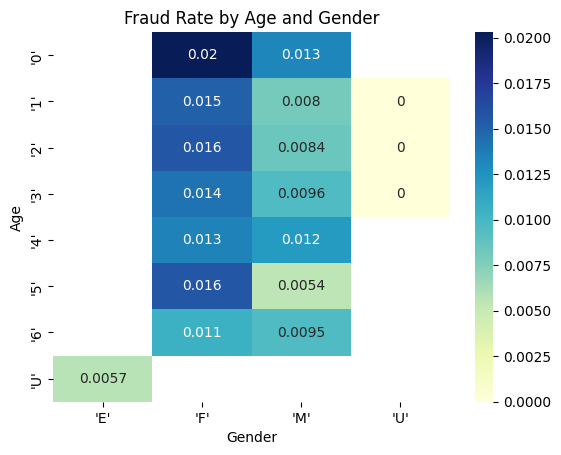

In [68]:
heatmap_data = df.groupby(['age', 'gender'])['fraud'].mean().unstack()
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title('Fraud Rate by Age and Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

> What it Means:
* Highest Risk Group: The most significant finding is that Gender 'F' in Age group '0' has the highest fraud rate at 0.02 (or 2%). In general, across most age groups, Gender 'F' shows higher fraud rates compared to Gender 'M'.

>* Gender 'M' Trend: Individuals in the 'M' gender category consistently have moderate to low fraud rates, generally lower than those in the 'F' category for the same age group.

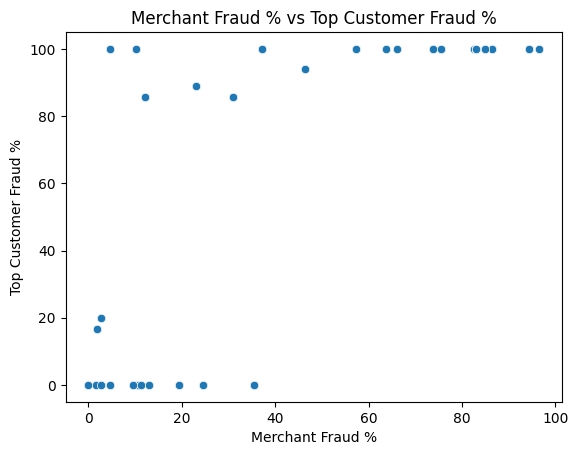

In [69]:
sns.scatterplot(data=df, x='merchant_fraud_percent', y='merchant_top_customer_fraud_percent')
plt.title("Merchant Fraud % vs Top Customer Fraud %")
plt.xlabel("Merchant Fraud %")
plt.ylabel("Top Customer Fraud %")
plt.show()

>What it Means:
Two Major Clusters: The data points are not scattered randomly but are grouped into two main areas.

Low-Fraud Zone (Bottom-Left): There is a dense cluster of merchants where both the merchant's fraud rate and their top customers' fraud rate are very low (mostly under 20%). This represents a "healthy" or low-risk group.

High-Customer-Fraud Zone (Top): There is a strong horizontal line of merchants where the Top Customer Fraud % is extremely high, at or near 100%.

"All-or-Nothing" Customer Fraud: The most striking insight is that there's very little middle ground for top customer fraud. It's either very low (under 20%) or nearly 100%. This suggests that when a merchant's top customers are fraudulent, they are overwhelmingly so.

Merchants as Potential Victims: In the top cluster, merchants exhibit a wide range of fraud rates (from <10% to 100%) while their top customers consistently show a ~100% fraud rate. This could imply that even merchants with low overall fraud can be targeted by highly fraudulent rings or customer groups.

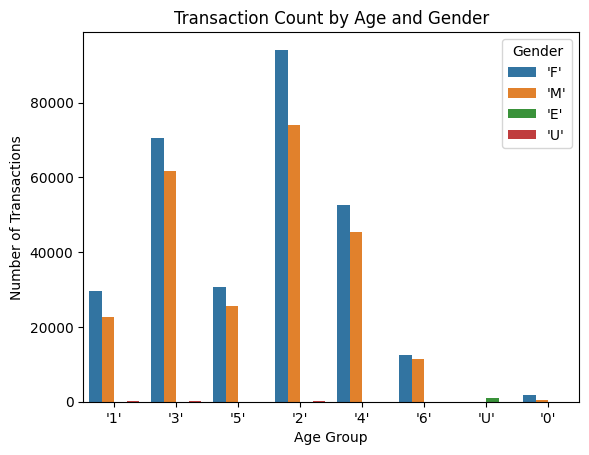

In [70]:
sns.countplot(data=df, x='age', hue='gender')
plt.title("Transaction Count by Age and Gender")
plt.xlabel("Age Group")
plt.ylabel("Number of Transactions")
plt.legend(title="Gender")
plt.show()

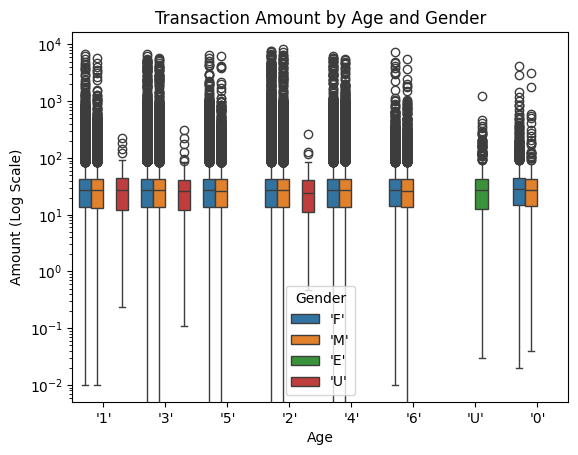

In [71]:
sns.boxplot(data=df, x='age', y='amount', hue='gender')
plt.yscale('log')  # If distribution is skewed
plt.title("Transaction Amount by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Amount (Log Scale)")
plt.legend(title="Gender")
plt.show()

>What it Means:


>* Consistent Typical Spending: The most important insight is the striking similarity of the boxes across almost all categories. The median transaction amount (the line inside the box) is nearly identical for every age and gender group, hovering around the 10 ^
1
  to 10 ^
2
  range (i.e., between $10 and $100). This means the typical, everyday spending behavior is very uniform across the customer base.

>* Outliers Tell the Story: While typical spending is consistent, the plot reveals numerous outliers, especially for genders 'F' and 'M'. These are the small circles extending up to and beyond 10
3
  ($1,000). This indicates that although the median transaction is low, a significant number of very high-value purchases occur within these groups.

>* Minimal Difference Between Genders: For the primary genders 'F' and 'M', there is almost no discernible difference in their spending distributions. Both the median and the spread (size of the box) are nearly identical in every age group.

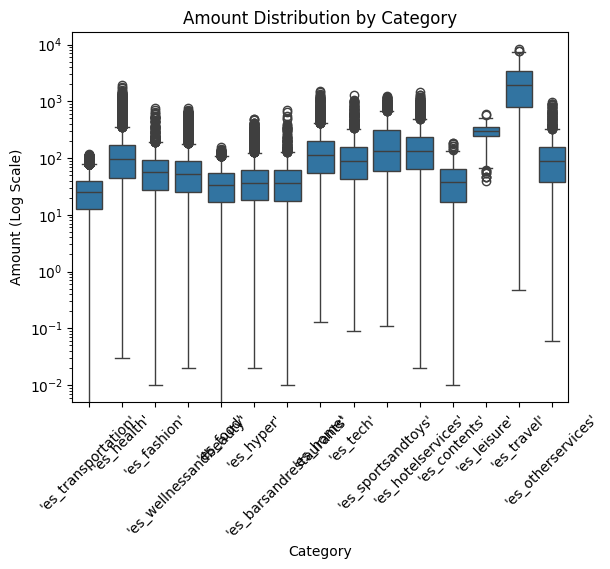

In [73]:
sns.boxplot(data=df, x='category', y='amount')
plt.xticks(rotation=45)
plt.yscale('log')
plt.title("Amount Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Amount (Log Scale)")
plt.show()

>What it Means:
>* Spending Varies Greatly by Category: Unlike the previous charts where spending was uniform, this plot shows that the typical transaction amount depends heavily on the purchase category.

>* High-Cost Categories Stand Out: 'es_travel' is the clear standout, with the highest median transaction amount (around $1000) and the largest spread (the tallest box). 'es_leisure' also has a significantly higher median spend than most other categories. This is intuitive, as flights and holidays cost more than a typical meal or bus fare.

>* Lower-Cost Categories: Most other categories, such as 'es_transportation', 'es_health', 'es_food', and 'es_fashion', have much lower median transaction amounts, generally falling between $20 and $100. Their smaller boxes indicate more consistent, less variable spending.

>* Widespread Outliers: Similar to previous plots, nearly every category has high-value outliers. This signifies that while the typical spend might be low in a category like 'es_food', exceptionally large purchases (like catering for an event) still happen.

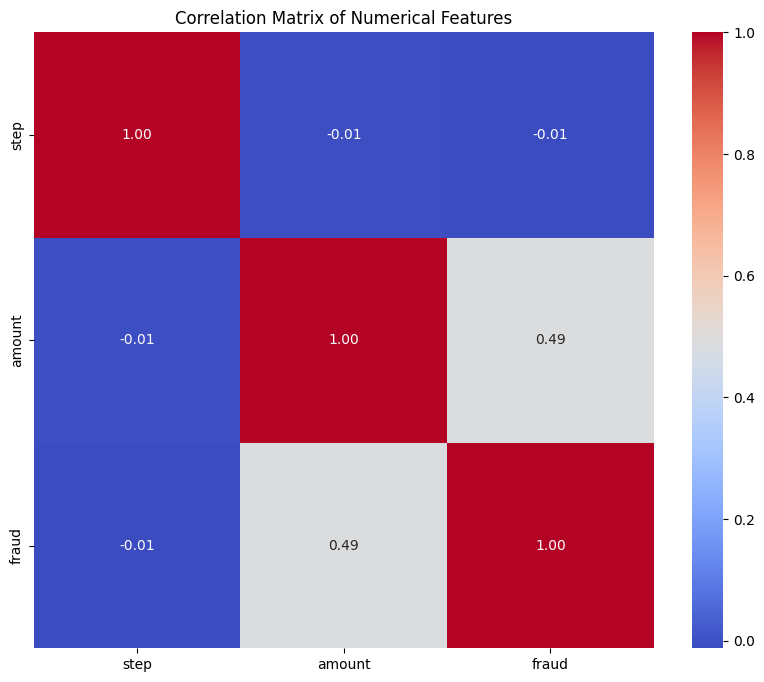

In [ ]:
# correlation matrix
correlation_matrix = df_up[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

> Correlation between amount and fraud (0.50):

The value of 0.50 indicates a moderate positive correlation.

As the transaction amount increases, the likelihood of that transaction being fraudulent also tends to increase. This can be attributed to the likelhood of Fraudsters attempting to steal larger sums of money.

## Insights from data:

> * The category with the highest transaction has 0% fraud wheras we can see in our data that categories with lower transaction have higher percent of fraud.

> * There is a huge imbalance in our target label fraud. ~99% data being in class 0 and 1% being in 1.

> * Unlike categories, where the highest occuring categories have the highest fraud amount, gender has the highest occuring ones committing the most fraud (F, followed by M)

> * Age also follows a similar pattern like gender with the highest occuring committing the most fraud.

> * There are 4102 unique customers with the most frequent being:
Value counts:
customer
'C1275518867'    61
'C806399525'     59
'C1978250683'    58
'C332727422'     51
'C1476491893'    49

> * The number of total merchants dealing is less with around 50 merchants. Most frequent are:
Value counts:
merchant
'M1823072687'    58423
'M348934600'     40118
'M85975013'       5118
'M1053599405'     1355
'M151143676'      1273

> * The zipCode and zipMerchant features are one value repeated and do not contribute much to our data.

# What can be done:

> Feature Engineering

> *Merchant-Level Risk Features: To provide deeper context, new features were engineered by grouping data by merchant.

> * Key Engineered Features: These include the merchant's total transaction count, overall fraud percentage (merchant_fraud_percent), and the fraud rate of their single most frequent customer (merchant_top_customer_fraud_percent). These features help the model identify high-risk merchants and concentrated fraudulent behavior.

> Data Preprocessing
> * Log Transformation: A log transformation is applied to the amount column to normalize its right-skewed distribution, which is common in financial data.

> * Scaling: StandardScaler is used to scale all numerical features, ensuring they have a mean of 0 and a standard deviation of 1, which helps improve model performance.

> * Encoding: Categorical features like age, gender, and category are converted into a numerical format using encoding techniques so the model can process them.

## Graph Neural Network (GNN) Approach
> Why a GNN?
> * A GNN is chosen because this data is inherently a graph. Transactions naturally link customers and merchants, creating a network. Unlike traditional models that view each transaction in isolation, a GNN can analyze the entire structure of these relationships, making it powerful for detecting complex fraud rings and coordinated activities.

> How it's Implemented:

* Nodes: Customers and merchants are defined as nodes in the graph.

* Edges: Each transaction between a customer and a merchant is represented as an edge connecting the corresponding nodes.

* Features: The preprocessed and engineered features (like scaled amount, category, and merchant fraud rate) are attached to these edges as attributes.

> How it Works
> * The GNN operates through a "message passing" mechanism. It learns by aggregating feature information from a node's neighbors. This allows the model to create sophisticated embeddings (representations) for each customer and merchant that are not just based on their own data, but also on the context of who they transact with. This contextual understanding is crucial for accurately identifying fraudulent patterns that would otherwise be hidden.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from torch_geometric.data import Data
from torch_geometric.nn import MetaLayer

In [ ]:
df = df.merge(final_sorted[['Total_Transactions', 'Fraud_%', 'Top_Customer', 'Top_Customer_Txns', 'Top_Customer_Fraud_%']],
              left_on='merchant', right_index=True, how='left')
df.rename(columns={
    'Total_Transactions': 'merchant_total_txns',
    'Fraud_%': 'merchant_fraud_percent',
    'Top_Customer': 'merchant_top_customer',
    'Top_Customer_Txns': 'merchant_top_customer_txns',
    'Top_Customer_Fraud_%': 'merchant_top_customer_fraud_percent'
}, inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535178 entries, 0 to 535177
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   step                                 535178 non-null  int64  
 1   customer                             535178 non-null  object 
 2   age                                  535178 non-null  object 
 3   gender                               535178 non-null  object 
 4   zipcodeOri                           535178 non-null  object 
 5   merchant                             535178 non-null  object 
 6   zipMerchant                          535178 non-null  object 
 7   category                             535178 non-null  object 
 8   amount                               535178 non-null  float64
 9   fraud                                535178 non-null  int64  
 10  merchant_total_txns                  535178 non-null  int64  
 11  merchant_frau

In [52]:
numerical_cols = ['step', 'amount', 'merchant_total_txns', 'merchant_fraud_percent', 'merchant_top_customer_txns', 'merchant_top_customer_fraud_percent']
ordinal_cols = ['age', 'gender']
ohe_cols = ['category', 'merchant_top_customer']

scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder()
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

scaled_numerical_features = scaler.fit_transform(df[numerical_cols])
encoded_ordinal_features = ordinal_encoder.fit_transform(df[ordinal_cols])
encoded_ohe_features = ohe_encoder.fit_transform(df[ohe_cols])

edge_attr = torch.cat([
    torch.tensor(scaled_numerical_features, dtype=torch.float),
    torch.tensor(encoded_ordinal_features, dtype=torch.float),
    torch.tensor(encoded_ohe_features, dtype=torch.float)
], dim=1)

# Create Node Mappings
all_nodes = pd.concat([df['customer'], df['merchant']]).unique()
node_to_idx = {node_id: i for i, node_id in enumerate(all_nodes)}
num_nodes = len(all_nodes)

# Create aggregated stats for customers to use as node features
customer_stats = df.groupby('customer').agg(
    customer_total_txns=('merchant', 'size'),
    customer_avg_amount=('amount', 'mean'),
    customer_fraud_rate=('fraud', 'mean')
).reset_index()

# Define dimensions for our node features
customer_feature_dim = 3  # (total_txns, avg_amount, fraud_rate)
merchant_feature_dim = 2  # (total_txns, fraud_%)
node_feature_dim = customer_feature_dim + merchant_feature_dim
node_features = torch.zeros((num_nodes, node_feature_dim), dtype=torch.float)

# Populate features for MERCHANT nodes
merchant_df = df.drop_duplicates(subset=['merchant']).set_index('merchant')
for merchant_id, row in merchant_df.iterrows():
    idx = node_to_idx[merchant_id]
    scaled_vals = scaler.transform([[row.step, row.amount, row.merchant_total_txns, row.merchant_fraud_percent, row.merchant_top_customer_txns, row.merchant_top_customer_fraud_percent]])
    node_features[idx, customer_feature_dim:] = torch.tensor(
        [scaled_vals[0, 2], scaled_vals[0, 3]], dtype=torch.float
    )

# Populate features for CUSTOMER nodes
customer_df = customer_stats.set_index('customer')
customer_scaler = StandardScaler()
scaled_customer_features = customer_scaler.fit_transform(customer_df[['customer_total_txns', 'customer_avg_amount', 'customer_fraud_rate']])
customer_df_scaled = pd.DataFrame(scaled_customer_features, index=customer_df.index, columns=customer_df.columns)
for customer_id, row in customer_df_scaled.iterrows():
    if customer_id in node_to_idx:
        idx = node_to_idx[customer_id]
        node_features[idx, :customer_feature_dim] = torch.tensor(row.values, dtype=torch.float)

# Finalize graph components
source_nodes = df['customer'].map(node_to_idx).values
dest_nodes = df['merchant'].map(node_to_idx).values
edge_index = torch.tensor(np.array([source_nodes, dest_nodes]), dtype=torch.long)
y = torch.tensor(df['fraud'].values, dtype=torch.float)

# Create the final Data object and train/test masks
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)
train_indices, test_indices = train_test_split(np.arange(data.num_edges), test_size=0.2, random_state=42, stratify=data.y.numpy())
train_mask = torch.zeros(data.num_edges, dtype=torch.bool)
test_mask = torch.zeros(data.num_edges, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

class EdgeModel(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim):
        super().__init__()
        self.edge_mlp = Sequential(Linear(2 * node_feat_dim + edge_feat_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
    def forward(self, src, dest, edge_attr, u, batch):
        return self.edge_mlp(torch.cat([src, dest, edge_attr], dim=1))

class NodeModel(torch.nn.Module):
    def __init__(self, node_feat_dim, hidden_dim):
        super().__init__()
        self.node_mlp = Sequential(Linear(node_feat_dim + hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        agg = torch.zeros(x.size(0), edge_attr.size(1), device=x.device).scatter_add_(0, row.unsqueeze(1).expand_as(edge_attr), edge_attr)
        return self.node_mlp(torch.cat([x, agg], dim=1))

class MetaLayerGNN(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim):
        super().__init__()
        self.meta_layer1 = MetaLayer(
            edge_model=EdgeModel(node_feat_dim, edge_feat_dim, hidden_dim),
            node_model=NodeModel(node_feat_dim, hidden_dim)
        )
        self.meta_layer2 = MetaLayer(
            edge_model=EdgeModel(hidden_dim, hidden_dim, hidden_dim),
            node_model=NodeModel(hidden_dim, hidden_dim)
        )
        self.mlp = Sequential(
            Linear(2 * hidden_dim + hidden_dim, hidden_dim),
            BatchNorm1d(hidden_dim),
            ReLU(),
            Linear(hidden_dim, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        x, edge_attr, _ = self.meta_layer1(x, edge_index, edge_attr)
        x, edge_attr, _ = self.meta_layer2(x, edge_index, edge_attr)
        source_nodes_emb = x[edge_index[0]]
        dest_nodes_emb = x[edge_index[1]]
        return self.mlp(torch.cat([source_nodes_emb, dest_nodes_emb, edge_attr], dim=1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayerGNN(
    node_feat_dim=data.num_node_features,
    edge_feat_dim=data.num_edge_features,
    hidden_dim=128
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_pos = data.y[data.train_mask].sum()
num_neg = len(data.y[data.train_mask]) - num_pos
pos_weight = num_neg / num_pos if num_pos > 0 else torch.tensor(1.0)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

data = data.to(device)

print("🚀 Starting model training...")
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr).squeeze()
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr).squeeze()
    probs = torch.sigmoid(out[data.test_mask]).cpu().numpy()
    true_labels = data.y[data.test_mask].cpu().numpy()

    auc_roc = roc_auc_score(true_labels, probs)
    print(f"\nTest AUC-ROC Score: {auc_roc:.4f}")

    print("\n--- Finding a Better Threshold ---")
    for threshold in [0.98]:
        print(f"\nMetrics for Threshold = {threshold}:")
        preds = (probs > threshold).astype(int)
        print(classification_report(true_labels, preds, target_names=['Class 0 (No Fraud)', 'Class 1 (Fraud)'], zero_division=0))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

🚀 Starting model training...
Epoch 000 | Train Loss: 1.2765
Epoch 025 | Train Loss: 0.5923
Epoch 050 | Train Loss: 0.2651
Epoch 075 | Train Loss: 0.1591
Epoch 100 | Train Loss: 0.1143
Epoch 125 | Train Loss: 0.0850
Epoch 150 | Train Loss: 0.0689
Epoch 175 | Train Loss: 0.0603
Epoch 200 | Train Loss: 0.0585
Epoch 225 | Train Loss: 0.0508
Epoch 250 | Train Loss: 0.0531
Epoch 275 | Train Loss: 0.0486

Test AUC-ROC Score: 0.9993

--- Finding a Better Threshold ---

Metrics for Threshold = 0.98:
                    precision    recall  f1-score   support

Class 0 (No Fraud)       1.00      1.00      1.00    105738
   Class 1 (Fraud)       0.89      0.88      0.89      1298

          accuracy                           1.00    107036
         macro avg       0.95      0.94      0.94    107036
      weighted avg       1.00      1.00      1.00    107036



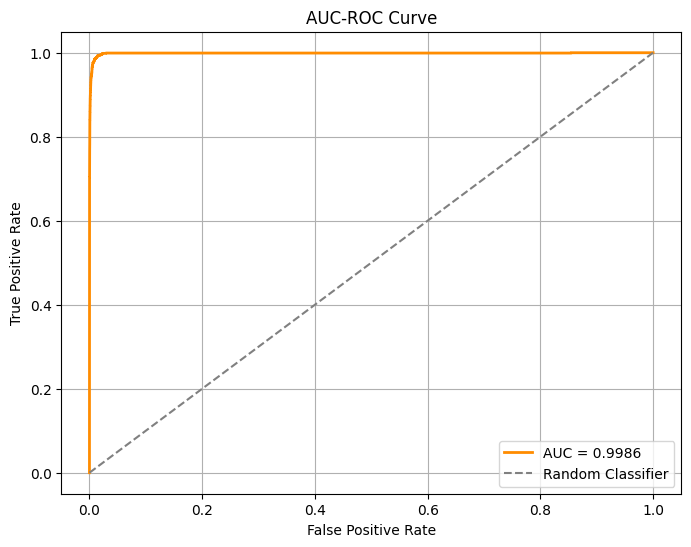

In [74]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = roc_auc_score(true_labels, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

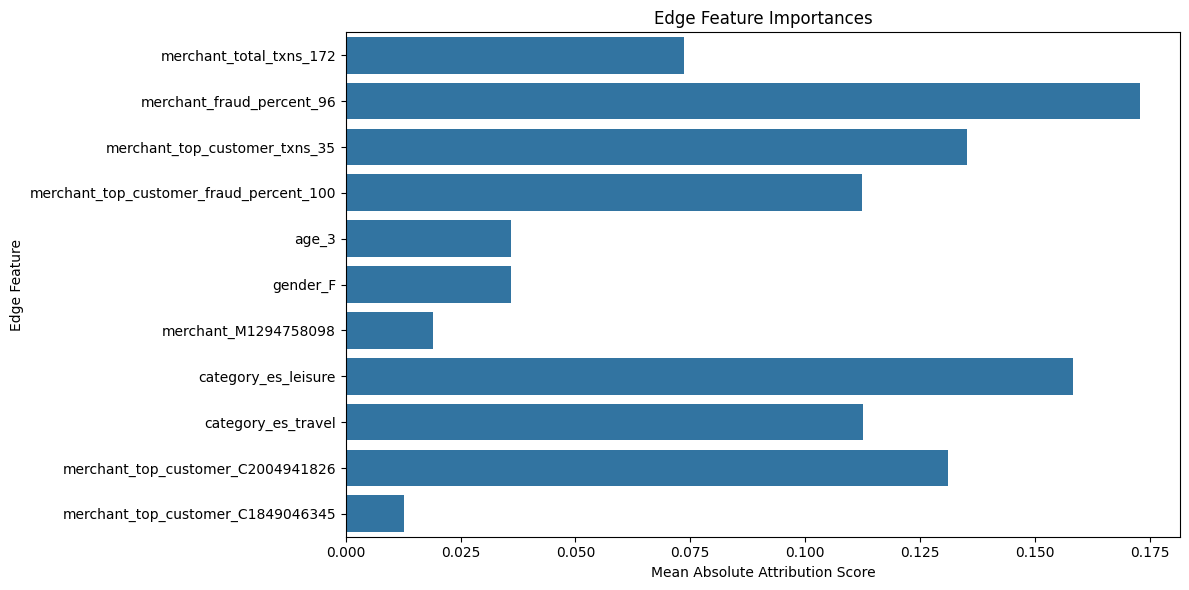

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.explain import Explainer, CaptumExplainer
from torch_geometric.explain.config import MaskType

model.eval()

test_y_np = data.y[data.test_mask].cpu().numpy()
test_preds_np = (probs > 0.95).astype(int)

# Find indices of true positives (correctly identified frauds)
true_positives_indices_local = np.where((test_y_np == 1) & (test_preds_np == 1))[0]

if len(true_positives_indices_local) == 0:
    print("No true positive fraud cases found in the test set to explain. Try another run or a lower threshold.")
else:
    # Map the local index back to the global edge index
    original_test_indices = np.where(data.test_mask.cpu().numpy())[0]
    edge_to_explain_idx = original_test_indices[true_positives_indices_local[0]]
    print(f"Explaining transaction (edge) with global index: {edge_to_explain_idx}")

    explainer = Explainer(
        model=model,
        algorithm=CaptumExplainer(attribution_method='Saliency'),
        explanation_type='model',
        model_config=dict(
            mode='binary_classification',
            task_level='edge',
            return_type='probs',
        ),
        node_mask_type=None,
        edge_mask_type=MaskType.object,
    )

    print("Running explainer... (this may take a moment)")

    index_tensor = torch.tensor([edge_to_explain_idx]).to(device)

    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        index=index_tensor
    )

    edge_attr_importance = explanation.edge_attr.abs().squeeze().cpu().numpy()

    # Create a complete list of feature names in the correct order
    ohe_feature_names = ohe_encoder.get_feature_names_out(ohe_cols)
    all_feature_names = numerical_cols + ordinal_cols + list(ohe_feature_names)

    # Create a DataFrame for easy visualization
    importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': edge_attr_importance
    }).sort_values('importance', ascending=False)

    print("\n--- Feature Importance Report ---")
    print(importance_df.head(15))

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance',
        y='feature',
        data=importance_df.head(15),
        palette='viridis'
    )
    plt.title('Top 15 Most Important Features for a Fraudulent Transaction')
    plt.xlabel('Importance (Saliency Score)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# XGBoost + GNN

In [78]:
print("\nPreprocessing data for XGBoost...")
X = df.drop(['fraud', 'zipcodeOri', 'zipMerchant'], axis=1)
y = df['fraud']

indices = df.index.values
X_train_idx, X_test_idx, y_train, y_test = train_test_split(indices, y, test_size=0.2, random_state=42, stratify=y)

X_train_df = X.loc[X_train_idx].copy()
X_test_df = X.loc[X_test_idx].copy()

# Define column types for XGBoost
xgb_numerical_cols = ['step', 'amount', 'merchant_total_txns', 'merchant_fraud_percent', 'merchant_top_customer_txns', 'merchant_top_customer_fraud_percent']
xgb_categorical_cols = ['age', 'gender', 'category', 'customer', 'merchant', 'merchant_top_customer']

# Scale numerical features
scaler_xgb = StandardScaler()
X_train_df[xgb_numerical_cols] = scaler_xgb.fit_transform(X_train_df[xgb_numerical_cols])
X_test_df[xgb_numerical_cols] = scaler_xgb.transform(X_test_df[xgb_numerical_cols])

# Ordinal encode categorical features for XGBoost
ordinal_encoder_xgb = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_df[xgb_categorical_cols] = ordinal_encoder_xgb.fit_transform(X_train_df[xgb_categorical_cols])
X_test_df[xgb_categorical_cols] = ordinal_encoder_xgb.transform(X_test_df[xgb_categorical_cols])

print("Training XGBoost model...")
# Use scale_pos_weight for better handling of imbalanced classes
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model.fit(X_train_df, y_train)
xgb_preds_proba = xgb_model.predict_proba(X_test_df)[:, 1]


print("\nPreprocessing data for GNN...")
# Define column types for GNN
gnn_numerical_cols = ['step', 'amount', 'merchant_total_txns', 'merchant_fraud_percent', 'merchant_top_customer_txns', 'merchant_top_customer_fraud_percent']
gnn_ordinal_cols = ['age', 'gender']
gnn_ohe_cols = ['category', 'merchant_top_customer']

# Encoders for GNN
scaler_gnn = StandardScaler()
ordinal_encoder_gnn = OrdinalEncoder()
ohe_encoder_gnn = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

scaled_numerical_features = scaler_gnn.fit_transform(df[gnn_numerical_cols])
encoded_ordinal_features = ordinal_encoder_gnn.fit_transform(df[gnn_ordinal_cols])
encoded_ohe_features = ohe_encoder_gnn.fit_transform(df[gnn_ohe_cols])

edge_attr = torch.cat([
    torch.tensor(scaled_numerical_features, dtype=torch.float),
    torch.tensor(encoded_ordinal_features, dtype=torch.float),
    torch.tensor(encoded_ohe_features, dtype=torch.float)
], dim=1)

# Node Mappings
all_nodes = pd.concat([df['customer'], df['merchant']]).unique()
node_to_idx = {node_id: i for i, node_id in enumerate(all_nodes)}
num_nodes = len(all_nodes)

# Node Features
customer_stats = df.groupby('customer').agg(
    customer_total_txns=('merchant', 'size'),
    customer_avg_amount=('amount', 'mean'),
    customer_fraud_rate=('fraud', 'mean')
).reset_index()

customer_feature_dim = 3
merchant_feature_dim = 2
node_feature_dim = customer_feature_dim + merchant_feature_dim
node_features = torch.zeros((num_nodes, node_feature_dim), dtype=torch.float)

merchant_df = df.drop_duplicates(subset=['merchant']).set_index('merchant')
for merchant_id, row in merchant_df.iterrows():
    idx = node_to_idx[merchant_id]
    scaled_vals = scaler_gnn.transform([row[gnn_numerical_cols]])
    node_features[idx, customer_feature_dim:] = torch.tensor(
        [scaled_vals[0, 2], scaled_vals[0, 3]], dtype=torch.float
    )

customer_df = customer_stats.set_index('customer')
customer_scaler = StandardScaler()
scaled_customer_features = customer_scaler.fit_transform(customer_df[['customer_total_txns', 'customer_avg_amount', 'customer_fraud_rate']])
customer_df_scaled = pd.DataFrame(scaled_customer_features, index=customer_df.index, columns=customer_df.columns)
for customer_id, row in customer_df_scaled.iterrows():
    if customer_id in node_to_idx:
        idx = node_to_idx[customer_id]
        node_features[idx, :customer_feature_dim] = torch.tensor(row.values, dtype=torch.float)

# Finalize graph components
source_nodes = df['customer'].map(node_to_idx).values
dest_nodes = df['merchant'].map(node_to_idx).values
edge_index = torch.tensor(np.array([source_nodes, dest_nodes]), dtype=torch.long)
y_gnn = torch.tensor(df['fraud'].values, dtype=torch.float)

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y_gnn)
train_mask = torch.zeros(data.num_edges, dtype=torch.bool)
test_mask = torch.zeros(data.num_edges, dtype=torch.bool)
train_mask[X_train_idx] = True
test_mask[X_test_idx] = True
data.train_mask = train_mask
data.test_mask = test_mask

# GNN Model Definition
class EdgeModel(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim):
        super().__init__()
        self.edge_mlp = Sequential(Linear(2 * node_feat_dim + edge_feat_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
    def forward(self, src, dest, edge_attr, u, batch):
        return self.edge_mlp(torch.cat([src, dest, edge_attr], dim=1))

class NodeModel(torch.nn.Module):
    def __init__(self, node_feat_dim, hidden_dim):
        super().__init__()
        self.node_mlp = Sequential(Linear(node_feat_dim + hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        agg = torch.zeros(x.size(0), edge_attr.size(1), device=x.device).scatter_add_(0, row.unsqueeze(1).expand_as(edge_attr), edge_attr)
        return self.node_mlp(torch.cat([x, agg], dim=1))

class MetaLayerGNN(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim):
        super().__init__()
        self.meta_layer1 = MetaLayer(
            edge_model=EdgeModel(node_feat_dim, edge_feat_dim, hidden_dim),
            node_model=NodeModel(node_feat_dim, hidden_dim)
        )
        self.meta_layer2 = MetaLayer(
            edge_model=EdgeModel(hidden_dim, hidden_dim, hidden_dim),
            node_model=NodeModel(hidden_dim, hidden_dim)
        )
        self.mlp = Sequential(
            Linear(2 * hidden_dim + hidden_dim, hidden_dim),
            BatchNorm1d(hidden_dim),
            ReLU(),
            Linear(hidden_dim, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        x, edge_attr, _ = self.meta_layer1(x, edge_index, edge_attr)
        x, edge_attr, _ = self.meta_layer2(x, edge_index, edge_attr)
        source_nodes_emb = x[edge_index[0]]
        dest_nodes_emb = x[edge_index[1]]
        return self.mlp(torch.cat([source_nodes_emb, dest_nodes_emb, edge_attr], dim=1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = MetaLayerGNN(
    node_feat_dim=data.num_node_features,
    edge_feat_dim=data.num_edge_features,
    hidden_dim=128
).to(device)

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
num_pos = data.y[data.train_mask].sum()
num_neg = len(data.y[data.train_mask]) - num_pos
pos_weight = num_neg / num_pos if num_pos > 0 else torch.tensor(1.0)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
data = data.to(device)

print("🚀 Starting GNN model training...")
for epoch in range(225):
    gnn_model.train()
    optimizer.zero_grad()
    out = gnn_model(data.x, data.edge_index, data.edge_attr).squeeze()
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f"Epoch {epoch:03d} | GNN Train Loss: {loss.item():.4f}")

gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, data.edge_index, data.edge_attr).squeeze()
    gnn_preds_proba = torch.sigmoid(out[data.test_mask]).cpu().numpy()

print("\n--- Evaluating Models ---")

xgb_weight = 0.5
gnn_weight = 0.5
ensemble_preds_proba = (xgb_weight * xgb_preds_proba) + (gnn_weight * gnn_preds_proba)

xgb_preds = (xgb_preds_proba > 0.5).astype(int)
gnn_preds = (gnn_preds_proba > 0.97).astype(int)
ensemble_preds = (ensemble_preds_proba > 0.5).astype(int)

print("\n--- Ensemble Model Evaluation ---")
print(classification_report(y_test, ensemble_preds, target_names=['No Fraud', 'Fraud']))
print(f"Ensemble ROC AUC: {roc_auc_score(y_test, ensemble_preds_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, ensemble_preds))


Preprocessing data for XGBoost...
Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:05:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Preprocessing data for GNN...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

🚀 Starting GNN model training...
Epoch 000 | GNN Train Loss: 1.6613
Epoch 025 | GNN Train Loss: 0.6140
Epoch 050 | GNN Train Loss: 0.2501
Epoch 075 | GNN Train Loss: 0.1629
Epoch 100 | GNN Train Loss: 0.1262
Epoch 125 | GNN Train Loss: 0.1032
Epoch 150 | GNN Train Loss: 0.0752
Epoch 175 | GNN Train Loss: 0.0639
Epoch 200 | GNN Train Loss: 0.0592

--- Evaluating Models ---

--- Ensemble Model Evaluation ---
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00    105738
       Fraud       0.69      0.69      0.69      1298

    accuracy                           0.99    107036
   macro avg       0.84      0.85      0.84    107036
weighted avg       0.99      0.99      0.99    107036

Ensemble ROC AUC: 0.9913
Confusion Matrix:
 [[105333    405]
 [   397    901]]


# XGBoost

In [79]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model.fit(X_train_df, y_train)
xgb_preds_proba = xgb_model.predict_proba(X_test_df)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:11:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [81]:
xgb_preds = (xgb_preds_proba >= 0.5).astype(int)

print(classification_report(y_test, xgb_preds, target_names=['No Fraud', 'Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99    105738
       Fraud       0.54      0.94      0.69      1298

    accuracy                           0.99    107036
   macro avg       0.77      0.96      0.84    107036
weighted avg       0.99      0.99      0.99    107036

